In [14]:
from method.split import split_folders
from method.cnn import CustomCNN, train_model, validate_model, predict_model
from method.io import load_data
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
import pandas as pd
import os
import random
#np.random.seed(420)

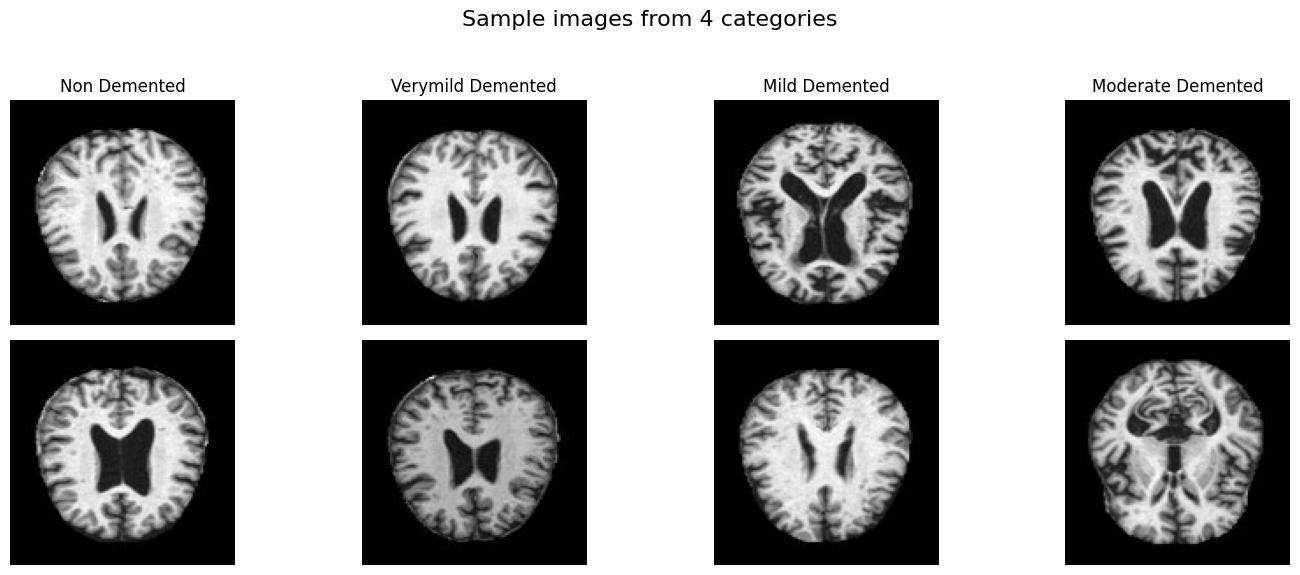

In [15]:
def extract_values_labels(data_list):
    values = [item[0] for item in data_list]
    labels = [item[1] for item in data_list]
    return values, labels

#==============================================================================
# Split filefolders

raw_data_path = 'raw_data'
processed_data_path = 'processed_data'
random_seed = 420
train_ratio, test_ratio, validation_ratio = (0.8, 0.1, 0.1)
split_ratio = [train_ratio, test_ratio, validation_ratio]

if not os.path.exists(processed_data_path):
    split_folders(raw_data_path, processed_data_path, random_seed, split_ratio)         

#==============================================================================
# Hyper parameters

layers = 4
kernel_num = 32
kernel_size = 3
pooling_size = 2
full_connection_neurons = 512
dropout = 0.2
learning_rate = 0.001
batch_size = 8
epoch = 10
optimizer = 'Adam'
activation = 'relu'
if_plot = True

#==============================================================================
# Load image after splited and Process it

filedir = 'processed_data'          # Directory of whole splited data
splits = ['train', 'test', 'val']           # Different uses of data
classifications = ['non', 'verymild', 'mild', 'moderate']      # Classification of disease degree

train_data, test_data, val_data = load_data(filedir, splits, classifications, transform = True, ifplot = if_plot)     # Load and transform img

In [3]:
random.seed(5)  # 设置随机种子
random.shuffle(test_data)
print(test_data[0])

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), [1, 0, 0, 0])


In [4]:
train_values, train_labels = extract_values_labels(train_data)          # (5119, 128, 128), (5119,)
test_values, test_labels = extract_values_labels(test_data)             # (642, 128, 128), (642,)
val_values, val_labels = extract_values_labels(val_data)                # (639, 128, 128), (639,)

train_images = torch.Tensor(np.array(train_values)).unsqueeze(1)
train_labels_tensor = torch.Tensor(train_labels)

test_images = torch.Tensor(np.array(test_values)).unsqueeze(1)
test_labels_tensor = torch.Tensor(test_labels)

val_images = torch.Tensor(np.array(val_values)).unsqueeze(1)
val_labels_tensor = torch.Tensor(val_labels)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])


In [5]:
train_dataset = TensorDataset(train_images, train_labels_tensor)
test_dataset = TensorDataset(test_images, test_labels_tensor)
val_dataset = TensorDataset(val_images, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(
    input_channels = 1, num_classes = len(classifications), layers = layers, 
    kernel_n = kernel_num, kernel_s = kernel_size, pooling_size = pooling_size,
    activation = activation, neurons = full_connection_neurons, dropout = dropout
)
model.to(device)

CustomCNN(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [6]:
train_model(model, train_loader, val_loader, epochs = 5, learning_rate = learning_rate, device = device)
predictions = predict_model(model, test_loader, device)         # shape: (642, 4)

The 0 epoch Validation Accuracy: 58.84%
The 1 epoch Validation Accuracy: 64.32%
The 2 epoch Validation Accuracy: 71.52%
The 3 epoch Validation Accuracy: 82.47%
The 4 epoch Validation Accuracy: 90.77%


In [7]:
print(predictions)

[[1.66094629e-03 9.91932690e-01 6.40641386e-03 1.11335314e-08]
 [9.99999285e-01 7.41895633e-07 1.40824641e-08 8.01496824e-09]
 [9.99999881e-01 1.26729333e-07 2.69872102e-09 1.54077312e-13]
 ...
 [1.29269147e-02 1.11441456e-01 8.75631571e-01 1.06957010e-09]
 [1.00000000e+00 8.58088150e-14 3.61870983e-15 4.83537069e-16]
 [2.34757718e-02 1.45330711e-03 1.75367098e-03 9.73317266e-01]]


In [11]:
one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1
print(one_hot_predictions)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [8]:
test_labels_tensor

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])

In [19]:
if not os.path.exists('out'):
    os.makedirs('out')

model_str = str(model)
with open('out/cnn_model.txt', 'w') as f:
    f.write(model_str)
model_path = 'out/cnn_model.pth'
torch.save(model.state_dict(), model_path)
np.save('out/prediction result.npy', one_hot_predictions)
np.save('out/test labels.npy', np.array(test_labels))